<a href="https://colab.research.google.com/github/riadc916/Research-paper/blob/main/Lrx_Research_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers scikit-learn pandas

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import AutoTokenizer

FILE_NAME = "Lrx-data - loan_dataset_1000_consistent.csv"

MODEL_NAME = "bert-base-multilingual-cased"

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print(f'User uploaded file "{fn}" with length {len(uploaded[fn])} bytes')

Saving Lrx-data - loan_dataset_1000_consistent.csv to Lrx-data - loan_dataset_1000_consistent.csv
User uploaded file "Lrx-data - loan_dataset_1000_consistent.csv" with length 162607 bytes


In [ ]:
df = pd.read_csv(FILE_NAME)

df = df.dropna(subset=['loan_comment', 'classification_label'])
df = df.reset_index(drop=True)

print(f"Total number of samples: {len(df)}")
print("--- Counts of Original Classification Labels ---")
print(df['classification_label'].value_counts())

le = LabelEncoder()
df['target_id'] = le.fit_transform(df['classification_label'])

print("\n--- Encoded Classification Labels (ID Map) ---")
target_map = dict(zip(df['target_id'], df['classification_label']))
print(target_map)

Total number of samples: 1000
--- Counts of Original Classification Labels ---
classification_label
Financial_Approval     600
Documentation_Issue    166
Asset_Risk             145
Financial_Risk          89
Name: count, dtype: int64

--- Encoded Classification Labels (ID Map) ---
{2: 'Financial_Approval', 3: 'Financial_Risk', 0: 'Asset_Risk', 1: 'Documentation_Issue'}


In [ ]:
import torch
from datasets import Dataset
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize_function(examples):
    return tokenizer(
        examples['loan_comment'],
        truncation=True,
        padding='max_length',
        max_length=128
    )

dataset = Dataset.from_pandas(df)

dataset_to_tokenize = dataset.select_columns(['loan_comment', 'target_id'])

tokenized_dataset = dataset_to_tokenize.map(tokenize_function, batched=True)

tokenized_dataset = tokenized_dataset.rename_column("target_id", "labels")

tokenized_dataset = tokenized_dataset.remove_columns(["loan_comment"])


train_val_test_split = tokenized_dataset.train_test_split(test_size=0.2, seed=42)
train_val_dataset = train_val_test_split['train']
test_dataset = train_val_test_split['test']

train_val_split = train_val_dataset.train_test_split(test_size=0.125, seed=42)
train_dataset = train_val_split['train']
val_dataset = train_val_split['test']

print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Training set size: 700
Validation set size: 100
Test set size: 200


In [ ]:
!pip install transformers datasets accelerate evaluate -U

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.5/511.5 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 24.2 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 18.1.0
    Uninstalling pyarrow-18.1.0:
      Successfully uninstalled pyarrow-18.1.0
  Attempting uninstall: datasets
    Found existing installation: datasets 4.0.0
    Uninstalling datasets-4.0.0:
      Successfully uninstalled datasets-4.0.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 22.0.0 which is incompatible.
pylibcudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 22.0.0 which is incompatible.


In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from transformers import AutoTokenizer

FILE_NAME = "Lrx-data - loan_dataset_1000_consistent.csv"
MODEL_NAME = "bert-base-multilingual-cased"

try:
    df = pd.read_csv(FILE_NAME)

    df = df.dropna(subset=['loan_comment', 'classification_label'])
    df = df.reset_index(drop=True)

    le = LabelEncoder()
    df['target_id'] = le.fit_transform(df['classification_label'])

    NUM_LABELS = len(le.classes_)

    print(f"MODEL_NAME successfully defined: {MODEL_NAME}")
    print(f"NUM_LABELS successfully defined: {NUM_LABELS}")
except Exception as e:
    print(f"Error during data loading/encoding: {e}. Please ensure the CSV file is uploaded.")

MODEL_NAME successfully defined: bert-base-multilingual-cased
NUM_LABELS successfully defined: 4


In [ ]:


import pandas as pd
import torch
from datasets import Dataset
from sklearn.preprocessing import LabelEncoder
from transformers import AutoTokenizer

FILE_NAME = "Lrx-data - loan_dataset_1000_consistent.csv"
MODEL_NAME = "bert-base-multilingual-cased"

df = pd.read_csv(FILE_NAME)
df = df.dropna(subset=['loan_comment', 'classification_label'])
df = df.reset_index(drop=True)

le = LabelEncoder()
df['target_id'] = le.fit_transform(df['classification_label'])
NUM_LABELS = len(le.classes_)


tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize_function(examples):
    return tokenizer(
        examples['loan_comment'],
        truncation=True,
        padding='max_length',
        max_length=128
    )

dataset = Dataset.from_pandas(df)
dataset_to_tokenize = dataset.select_columns(['loan_comment', 'target_id'])

tokenized_dataset = dataset_to_tokenize.map(tokenize_function, batched=True)

tokenized_dataset = tokenized_dataset.rename_column("target_id", "labels")

tokenized_dataset = tokenized_dataset.remove_columns(["loan_comment"])

train_val_test_split = tokenized_dataset.train_test_split(test_size=0.2, seed=42)
train_val_dataset = train_val_test_split['train']
test_dataset = train_val_test_split['test']

train_val_split = train_val_dataset.train_test_split(test_size=0.125, seed=42)
train_dataset = train_val_split['train']
val_dataset = train_val_split['test']

print(f"Data loading and splitting complete. Train size: {len(train_dataset)}, Validation size: {len(val_dataset)}, NUM_LABELS: {NUM_LABELS}")

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Data loading and splitting complete. Train size: 700, Validation size: 100, NUM_LABELS: 4


In [ ]:
!pip install evaluate -U


import pandas as pd
import torch
from datasets import Dataset
from sklearn.preprocessing import LabelEncoder
from transformers import AutoTokenizer

FILE_NAME = "Lrx-data - loan_dataset_1000_consistent.csv"
MODEL_NAME = "bert-base-multilingual-cased"


try:
    df = pd.read_csv(FILE_NAME)
except FileNotFoundError:
    print(f"Error: Could not find the file {FILE_NAME}. Please ensure it is in the current directory.")
    raise

df = df.dropna(subset=['loan_comment', 'classification_label'])
df = df.reset_index(drop=True)


le = LabelEncoder()
df['target_id'] = le.fit_transform(df['classification_label'])
NUM_LABELS = len(le.classes_)


causal_le = LabelEncoder()
df['causal_id'] = causal_le.fit_transform(df['causal_ratio'])
NUM_CAUSAL_LABELS = len(causal_le.classes_)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize_function(examples):
    return tokenizer(
        examples['loan_comment'],
        truncation=True,
        padding='max_length',
        max_length=128
    )

dataset_mtl = Dataset.from_pandas(df)
dataset_to_tokenize_mtl = dataset_mtl.select_columns(['loan_comment', 'target_id', 'causal_id'])

dataset_to_tokenize_mtl = dataset_to_tokenize_mtl.rename_column("target_id", "labels")

tokenized_dataset_mtl = dataset_to_tokenize_mtl.map(tokenize_function, batched=True)


cols_to_remove = ["loan_comment"]
if "__index_level_0__" in tokenized_dataset_mtl.column_names:
    cols_to_remove.append("__index_level_0__")

tokenized_dataset_mtl = tokenized_dataset_mtl.remove_columns(cols_to_remove)

mtl_train_val_test_split = tokenized_dataset_mtl.train_test_split(test_size=0.2, seed=42)
mtl_train_val_dataset = mtl_train_val_test_split['train']
mtl_test_dataset = mtl_train_val_test_split['test']

mtl_train_split = mtl_train_val_dataset.train_test_split(test_size=0.125, seed=42)
mtl_train_dataset = mtl_train_split['train']
mtl_val_dataset = mtl_train_split['test']

print("\n--- All Prerequisites and Multi-Task Datasets are Ready! ---")
print(f"MTL Training set size: {len(mtl_train_dataset)}, Classification Labels: {NUM_LABELS}, Causal Labels: {NUM_CAUSAL_LABELS}")

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]


--- All Prerequisites and Multi-Task Datasets are Ready! ---
MTL Training set size: 700, Classification Labels: 4, Causal Labels: 13


In [ ]:

!pip install evaluate -U

import pandas as pd
import torch
from datasets import Dataset
from sklearn.preprocessing import LabelEncoder
from transformers import AutoTokenizer

FILE_NAME = "Lrx-data - loan_dataset_1000_consistent.csv"
MODEL_NAME = "bert-base-multilingual-cased"

try:
    df = pd.read_csv(FILE_NAME)
except FileNotFoundError:
    print(f"Error: Could not find the file {FILE_NAME}. Please ensure it is in the current directory.")
    raise

df = df.dropna(subset=['loan_comment', 'classification_label'])
df = df.reset_index(drop=True)

le = LabelEncoder()
df['target_id'] = le.fit_transform(df['classification_label'])
NUM_LABELS = len(le.classes_)

causal_le = LabelEncoder()
df['causal_id'] = causal_le.fit_transform(df['causal_ratio'])
NUM_CAUSAL_LABELS = len(causal_le.classes_)


tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize_function(examples):
    return tokenizer(
        examples['loan_comment'],
        truncation=True,
        padding='max_length',
        max_length=128
    )

dataset_mtl = Dataset.from_pandas(df)
dataset_to_tokenize_mtl = dataset_mtl.select_columns(['loan_comment', 'target_id', 'causal_id'])

dataset_to_tokenize_mtl = dataset_to_tokenize_mtl.rename_column("target_id", "labels")

tokenized_dataset_mtl = dataset_to_tokenize_mtl.map(tokenize_function, batched=True)

cols_to_remove = ["loan_comment"]
if "__index_level_0__" in tokenized_dataset_mtl.column_names:
    cols_to_remove.append("__index_level_0__")

tokenized_dataset_mtl = tokenized_dataset_mtl.remove_columns(cols_to_remove)

mtl_train_val_test_split = tokenized_dataset_mtl.train_test_split(test_size=0.2, seed=42)
mtl_train_val_dataset = mtl_train_val_test_split['train']
mtl_test_dataset = mtl_train_val_test_split['test']

mtl_train_split = mtl_train_val_dataset.train_test_split(test_size=0.125, seed=42)
mtl_train_dataset = mtl_train_split['train']
mtl_val_dataset = mtl_train_split['test']

print("\n--- All Prerequisites and Multi-Task Datasets are Ready! ---")
print(f"MTL Training set size: {len(mtl_train_dataset)}, Classification Labels: {NUM_LABELS}, Causal Labels: {NUM_CAUSAL_LABELS}")

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]


--- All Prerequisites and Multi-Task Datasets are Ready! ---
MTL Training set size: 700, Classification Labels: 4, Causal Labels: 13


In [ ]:
import torch
import numpy as np
import evaluate
from torch import nn
from transformers import BertPreTrainedModel, BertModel, TrainingArguments, Trainer, AutoConfig
from torch.nn import CrossEntropyLoss

class BertMultiTaskClassifier(BertPreTrainedModel):
    """
    A BERT model with two classification heads:
    Task 1: Classification Label, Task 2: Causal Ratio ID.
    """
    def __init__(self, config, *args, **kwargs):
        super().__init__(config, *args, **kwargs)

        self.num_labels = config.num_labels
        self.num_causal_labels = config.num_causal_labels

        self.bert = BertModel(config)
        self.classifier = nn.Linear(config.hidden_size, self.num_labels)
        self.causal_classifier = nn.Linear(config.hidden_size, self.num_causal_labels)

        self.post_init()

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        labels=None,
        causal_id=None,
    ):
        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            return_dict=True,
        )

        pooled_output = outputs.pooler_output
        classification_logits = self.classifier(pooled_output)
        causal_logits = self.causal_classifier(pooled_output)

        total_loss = None
        if labels is not None and causal_id is not None:
            loss_fct = CrossEntropyLoss()
            loss_classification = loss_fct(classification_logits.view(-1, self.num_labels), labels.view(-1))
            loss_causal = loss_fct(causal_logits.view(-1, self.num_causal_labels), causal_id.view(-1))

            total_loss = loss_classification + loss_causal

        return (total_loss, classification_logits, causal_logits)



config = AutoConfig.from_pretrained(MODEL_NAME)

config.num_labels = NUM_LABELS
config.num_causal_labels = NUM_CAUSAL_LABELS


print("Loading Multi-Task BERT Model...")
mtl_model = BertMultiTaskClassifier.from_pretrained(
    MODEL_NAME,
    config=config
)


mtl_training_args = TrainingArguments(
    output_dir="./results_mtl",
    num_train_epochs=5,
    learning_rate=3e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs_mtl',
    logging_steps=100,
    report_to="none"
)

def compute_mtl_metrics(eval_pred):
    classification_logits = eval_pred.predictions[0] if isinstance(eval_pred.predictions, tuple) else eval_pred.predictions
    labels = eval_pred.label_ids[0] if isinstance(eval_pred.label_ids, tuple) else eval_pred.label_ids

    accuracy = evaluate.load("accuracy").compute(predictions=np.argmax(classification_logits, axis=-1), references=labels)
    f1 = evaluate.load("f1").compute(predictions=np.argmax(classification_logits, axis=-1), references=labels, average='weighted')

    return {"accuracy": accuracy["accuracy"], "f1_weighted": f1["f1"]}


mtl_trainer = Trainer(
    model=mtl_model,
    args=mtl_training_args,
    train_dataset=mtl_train_dataset,
    eval_dataset=mtl_val_dataset,
    compute_metrics=compute_mtl_metrics,
)


print("Starting the Multi-Task Fine-tuning process...")
mtl_trainer.train()
print("MTL Training complete!")

Loading Multi-Task BERT Model...


Some weights of BertMultiTaskClassifier were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['causal_classifier.bias', 'causal_classifier.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting the Multi-Task Fine-tuning process...


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
100,3.566700
200,3.021500
300,2.921700
400,2.892100


MTL Training complete!


In [ ]:

!pip install evaluate -U

import pandas as pd
import torch
import numpy as np
import evaluate
from datasets import Dataset
from sklearn.preprocessing import LabelEncoder
from torch import nn
from transformers import AutoTokenizer, BertPreTrainedModel, BertModel, TrainingArguments, Trainer, AutoConfig
from torch.nn import CrossEntropyLoss

FILE_NAME = "Lrx-data - loan_dataset_1000_consistent.csv"
MODEL_NAME = "bert-base-multilingual-cased"

try:
    df = pd.read_csv(FILE_NAME)
except FileNotFoundError:
    print(f"Error: Could not find the file {FILE_NAME}. Please ensure it is in the current directory.")
    raise

df = df.dropna(subset=['loan_comment', 'classification_label'])
df = df.reset_index(drop=True)

le = LabelEncoder()
df['target_id'] = le.fit_transform(df['classification_label'])
NUM_LABELS = len(le.classes_)

causal_le = LabelEncoder()
df['causal_id'] = causal_le.fit_transform(df['causal_ratio'])
NUM_CAUSAL_LABELS = len(causal_le.classes_)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize_function(examples):
    return tokenizer(
        examples['loan_comment'],
        truncation=True,
        padding='max_length',
        max_length=128
    )

dataset_mtl = Dataset.from_pandas(df)
dataset_to_tokenize_mtl = dataset_mtl.select_columns(['loan_comment', 'target_id', 'causal_id'])
dataset_to_tokenize_mtl = dataset_to_tokenize_mtl.rename_column("target_id", "labels")
tokenized_dataset_mtl = dataset_to_tokenize_mtl.map(tokenize_function, batched=True)

cols_to_remove = ["loan_comment"]
if "__index_level_0__" in tokenized_dataset_mtl.column_names:
    cols_to_remove.append("__index_level_0__")
tokenized_dataset_mtl = tokenized_dataset_mtl.remove_columns(cols_to_remove)

mtl_train_val_test_split = tokenized_dataset_mtl.train_test_split(test_size=0.2, seed=42)
mtl_train_val_dataset = mtl_train_val_test_split['train']
mtl_test_dataset = mtl_train_val_test_split['test']

mtl_train_split = mtl_train_val_dataset.train_test_split(test_size=0.125, seed=42)
mtl_train_dataset = mtl_train_split['train']
mtl_val_dataset = mtl_train_split['test']

print("--- Data Preparation Complete ---")
print(f"MTL Training set size: {len(mtl_train_dataset)}, Causal Labels: {NUM_CAUSAL_LABELS}")


class BertMultiTaskClassifier(BertPreTrainedModel):
    def __init__(self, config, *args, **kwargs):
        super().__init__(config, *args, **kwargs)
        self.num_labels = config.num_labels
        self.num_causal_labels = config.num_causal_labels
        self.bert = BertModel(config)
        self.classifier = nn.Linear(config.hidden_size, self.num_labels)
        self.causal_classifier = nn.Linear(config.hidden_size, self.num_causal_labels)
        self.post_init()

    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, labels=None, causal_id=None):
        outputs = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, return_dict=True)
        pooled_output = outputs.pooler_output
        classification_logits = self.classifier(pooled_output)
        causal_logits = self.causal_classifier(pooled_output)
        total_loss = None
        if labels is not None and causal_id is not None:
            loss_fct = CrossEntropyLoss()
            loss_classification = loss_fct(classification_logits.view(-1, self.num_labels), labels.view(-1))
            loss_causal = loss_fct(causal_logits.view(-1, self.num_causal_labels), causal_id.view(-1))
            total_loss = loss_classification + loss_causal
        return (total_loss, classification_logits, causal_logits)


config = AutoConfig.from_pretrained(MODEL_NAME)
config.num_labels = NUM_LABELS
config.num_causal_labels = NUM_CAUSAL_LABELS

print("Loading Multi-Task BERT Model...")
mtl_model = BertMultiTaskClassifier.from_pretrained(MODEL_NAME, config=config)

mtl_training_args = TrainingArguments(
    output_dir="./results_mtl", num_train_epochs=5, learning_rate=3e-5, per_device_train_batch_size=8,
    per_device_eval_batch_size=8, warmup_steps=500, weight_decay=0.01, logging_dir='./logs_mtl',
    logging_steps=100, report_to="none"
)

def compute_mtl_metrics(eval_pred):
    classification_logits = eval_pred.predictions[0] if isinstance(eval_pred.predictions, tuple) else eval_pred.predictions
    labels = eval_pred.label_ids[0] if isinstance(eval_pred.label_ids, tuple) else eval_pred.label_ids

    accuracy = evaluate.load("accuracy").compute(predictions=np.argmax(classification_logits, axis=-1), references=labels)
    f1 = evaluate.load("f1").compute(predictions=np.argmax(classification_logits, axis=-1), references=labels, average='weighted')

    return {"accuracy": accuracy["accuracy"], "f1_weighted": f1["f1"]}


mtl_trainer = Trainer(
    model=mtl_model, args=mtl_training_args, train_dataset=mtl_train_dataset, eval_dataset=mtl_val_dataset,
    compute_metrics=compute_mtl_metrics,
)

print("Starting the Multi-Task Fine-tuning process...")
mtl_trainer.train()
print("MTL Training complete!")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

--- Data Preparation Complete ---
MTL Training set size: 700, Causal Labels: 13
Loading Multi-Task BERT Model...


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertMultiTaskClassifier were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['causal_classifier.bias', 'causal_classifier.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting the Multi-Task Fine-tuning process...


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
100,3.544800
200,3.015400
300,2.913200
400,2.892400


MTL Training complete!


In [ ]:
print("\n--- Final MTL Evaluation on Test Set ---")

mtl_results = mtl_trainer.evaluate(mtl_test_dataset)
print(mtl_results)


--- Final MTL Evaluation on Test Set ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 2.8693785667419434, 'eval_accuracy': 0.585, 'eval_f1_weighted': 0.4318296529968454, 'eval_runtime': 76.2347, 'eval_samples_per_second': 2.623, 'eval_steps_per_second': 0.328, 'epoch': 5.0}


In [ ]:
import pandas as pd
import random
import re
from datasets import Dataset
from sklearn.preprocessing import LabelEncoder
from transformers import AutoTokenizer

FILE_NAME = "Lrx-data - loan_dataset_1000_consistent.csv"
MODEL_NAME = "bert-base-multilingual-cased"

df = pd.read_csv(FILE_NAME)
df = df.dropna(subset=['loan_comment', 'classification_label', 'causal_ratio'])
df = df.reset_index(drop=True)


le = LabelEncoder()
df['target_id'] = le.fit_transform(df['classification_label'])
NUM_LABELS = len(le.classes_)

causal_le = LabelEncoder()
df['causal_id'] = causal_le.fit_transform(df['causal_ratio'])
NUM_CAUSAL_LABELS = len(causal_le.classes_)

SUBSTITUTIONS = {
    "Approved": ["Sanctioned", "Accepted", "Cleared", "Verified"],
    "Rejected": ["Declined", "Denied", "Turned down", "Refused"],
    "High": ["Excellent", "Strong", "Good", "Great"],
    "Low": ["Poor", "Weak", "Insufficient", "Bad"],
    "Score": ["Rating", "Standing", "Grade"],
    "Risk": ["Danger", "Exposure", "Threat"],
    "CIBIL": ["Credit Score", "Financial Rating"],
    "Missing": ["Absent", "Unavailable", "Lacking"],
    "Issue": ["Problem", "Concern", "Matter"],
    "Proof of ownership": ["Title documents", "Property deeds", "Legal papers"],
}

def augment_comment(comment):
    new_comment = comment
    comment_words = set(re.findall(r'\b\w+\b', comment))
    substitutable_words = [word for word in comment_words if word in SUBSTITUTIONS]

    num_substitutions = random.choice([1, 2])
    words_to_substitute = random.sample(substitutable_words, min(num_substitutions, len(substitutable_words)))

    for word in words_to_substitute:
        replacement = random.choice(SUBSTITUTIONS[word])

        new_comment = re.sub(r'\b' + re.escape(word) + r'\b', replacement, new_comment, 1)

    return new_comment

new_rows = []
AUGMENTATION_FACTOR = 4

for index, row in df.iterrows():
    original_comment = row['loan_comment']

    new_rows.append(row.to_dict())

    for i in range(AUGMENTATION_FACTOR):
        augmented_comment = augment_comment(original_comment)

        new_row_dict = {
            'loan_comment': augmented_comment,

            'loan_status': row['loan_status'],
            'classification_label': row['classification_label'],
            'causal_ratio': row['causal_ratio'],
            'target_id': row['target_id'],
            'causal_id': row['causal_id'],
            'cibil_score': row['cibil_score'],
            'language': row['language']
        }
        new_rows.append(new_row_dict)

df_augmented = pd.DataFrame(new_rows)
df_augmented = df_augmented.reset_index(drop=True)

print(f"Original Data Size: {len(df)}")
print(f"Augmented Data Size: {len(df_augmented)}")
print(f"First 5 Augmented Samples:")
print(df_augmented[['loan_comment', 'classification_label', 'causal_ratio']].head())
df = df_augmented.copy()

Original Data Size: 1000
Augmented Data Size: 5000
First 5 Augmented Samples:
                                        loan_comment classification_label  \
0  Collateral valuation is too low to secure the ...   Financial_Approval   
1  Collateral valuation is too low to secure the ...   Financial_Approval   
2  Collateral valuation is too low to secure the ...   Financial_Approval   
3  Collateral valuation is too low to secure the ...   Financial_Approval   
4  Collateral valuation is too low to secure the ...   Financial_Approval   

                                    causal_ratio  
0  High CIBIL Score (Cause) -> Approved (Effect)  
1  High CIBIL Score (Cause) -> Approved (Effect)  
2  High CIBIL Score (Cause) -> Approved (Effect)  
3  High CIBIL Score (Cause) -> Approved (Effect)  
4  High CIBIL Score (Cause) -> Approved (Effect)  


In [ ]:
import torch
import numpy as np
from datasets import Dataset
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize_function(examples):
    return tokenizer(
        examples['loan_comment'],
        truncation=True,
        padding='max_length',
        max_length=128
    )

dataset_mtl = Dataset.from_pandas(df)
dataset_to_tokenize_mtl = dataset_mtl.select_columns(['loan_comment', 'target_id', 'causal_id'])

dataset_to_tokenize_mtl = dataset_to_tokenize_mtl.rename_column("target_id", "labels")

print("Tokenizing 5000 augmented samples...")
tokenized_dataset_mtl = dataset_to_tokenize_mtl.map(tokenize_function, batched=True)

cols_to_remove = ["loan_comment"]
if "__index_level_0__" in tokenized_dataset_mtl.column_names:
    cols_to_remove.append("__index_level_0__")

tokenized_dataset_mtl = tokenized_dataset_mtl.remove_columns(cols_to_remove)


mtl_train_val_test_split = tokenized_dataset_mtl.train_test_split(test_size=0.1, seed=42)
mtl_train_val_dataset = mtl_train_val_test_split['train']
mtl_test_dataset = mtl_train_val_test_split['test']


mtl_train_split = mtl_train_val_dataset.train_test_split(test_size=(1/9), seed=42)
mtl_train_dataset = mtl_train_split['train']
mtl_val_dataset = mtl_train_split['test']

print("\n--- Data Re-Preparation Complete (5000 Samples) ---")
print(f"New MTL Training set size: {len(mtl_train_dataset)} (80%)")
print(f"New Validation set size: {len(mtl_val_dataset)} (10%)")
print(f"New Test set size: {len(mtl_test_dataset)} (10%)")

Tokenizing 5000 augmented samples...


Map:   0%|          | 0/5000 [00:00<?, ? examples/s]


--- Data Re-Preparation Complete (5000 Samples) ---
New MTL Training set size: 4000 (80%)
New Validation set size: 500 (10%)
New Test set size: 500 (10%)


In [ ]:
import torch
import numpy as np
import evaluate
from torch import nn
from transformers import BertPreTrainedModel, BertModel, TrainingArguments, Trainer, AutoConfig
from torch.nn import CrossEntropyLoss

class BertMultiTaskClassifier(BertPreTrainedModel):
    def __init__(self, config, *args, **kwargs):
        super().__init__(config, *args, **kwargs)

        self.num_labels = config.num_labels
        self.num_causal_labels = config.num_causal_labels

        self.bert = BertModel(config)
        self.classifier = nn.Linear(config.hidden_size, self.num_labels)
        self.causal_classifier = nn.Linear(config.hidden_size, self.num_causal_labels)

        self.post_init()

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        labels=None,
        causal_id=None,
    ):
        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            return_dict=True,
        )

        pooled_output = outputs.pooler_output
        classification_logits = self.classifier(pooled_output)
        causal_logits = self.causal_classifier(pooled_output)

        total_loss = None
        if labels is not None and causal_id is not None:
            loss_fct = CrossEntropyLoss()
            loss_classification = loss_fct(classification_logits.view(-1, self.num_labels), labels.view(-1))
            loss_causal = loss_fct(causal_logits.view(-1, self.num_causal_labels), causal_id.view(-1))

            total_loss = loss_classification + (0.5 * loss_causal)

        return (total_loss, classification_logits, causal_logits)


config = AutoConfig.from_pretrained(MODEL_NAME)
config.num_labels = NUM_LABELS
config.num_causal_labels = NUM_CAUSAL_LABELS

print("Loading Multi-Task BERT Model for 5000 samples...")
mtl_model = BertMultiTaskClassifier.from_pretrained(MODEL_NAME, config=config)


mtl_training_args = TrainingArguments(
    output_dir="./results_mtl_v3",
    num_train_epochs=5,
    learning_rate=3e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs_mtl_v3',
    logging_steps=100,
    report_to="none"
)

def compute_mtl_metrics(eval_pred):
    classification_logits = eval_pred.predictions[0] if isinstance(eval_pred.predictions, tuple) else eval_pred.predictions
    labels = eval_pred.label_ids[0] if isinstance(eval_pred.label_ids, tuple) else eval_pred.label_ids

    accuracy = evaluate.load("accuracy").compute(predictions=np.argmax(classification_logits, axis=-1), references=labels)
    f1 = evaluate.load("f1").compute(predictions=np.argmax(classification_logits, axis=-1), references=labels, average='weighted')

    return {"accuracy": accuracy["accuracy"], "f1_weighted": f1["f1"]}


mtl_trainer = Trainer(
    model=mtl_model, args=mtl_training_args, train_dataset=mtl_train_dataset, eval_dataset=mtl_val_dataset,
    compute_metrics=compute_mtl_metrics,
)


print("Starting the Multi-Task Fine-tuning process with 5000 samples (Expected Performance Boost)...")
mtl_trainer.train()
print("MTL Training complete!")

Some weights of BertMultiTaskClassifier were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['causal_classifier.bias', 'causal_classifier.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading Multi-Task BERT Model for 5000 samples...
Starting the Multi-Task Fine-tuning process with 5000 samples (Expected Performance Boost)...


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
100,2.398600
200,2.051300
300,1.977300
400,2.010700
500,1.913700
600,1.953800
700,1.936300
800,1.925800
900,1.850500
1000,1.861600


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
100,2.398600
200,2.051300
300,1.977300
400,2.010700
500,1.913700
600,1.953800
700,1.936300
800,1.925800
900,1.850500
1000,1.861600


MTL Training complete!


In [ ]:
print("\n--- Final MTL Evaluation on Test Set (V3: 5000 Samples) ---")

mtl_results_v3 = mtl_trainer.evaluate(mtl_test_dataset)
print(mtl_results_v3)


--- Final MTL Evaluation on Test Set (V3: 5000 Samples) ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 1.8307446241378784, 'eval_accuracy': 0.6, 'eval_f1_weighted': 0.45, 'eval_runtime': 173.4568, 'eval_samples_per_second': 2.883, 'eval_steps_per_second': 0.363, 'epoch': 5.0}


In [ ]:

mtl_trainer.save_model("./final_mtl_model_v3")
print("Final model saved successfully to ./final_mtl_model_v3")

Final model saved successfully to ./final_mtl_model_v3


In [ ]:
mtl_trainer.save_model("./final_mtl_model_v3_f1_450")
print("Final model saved successfully to ./final_mtl_model_v3_f1_450")

Final model saved successfully to ./final_mtl_model_v3_f1_450


In [ ]:

training_history = mtl_trainer.state.log_history
print(f"Total log entries: {len(training_history)}")

Total log entries: 27


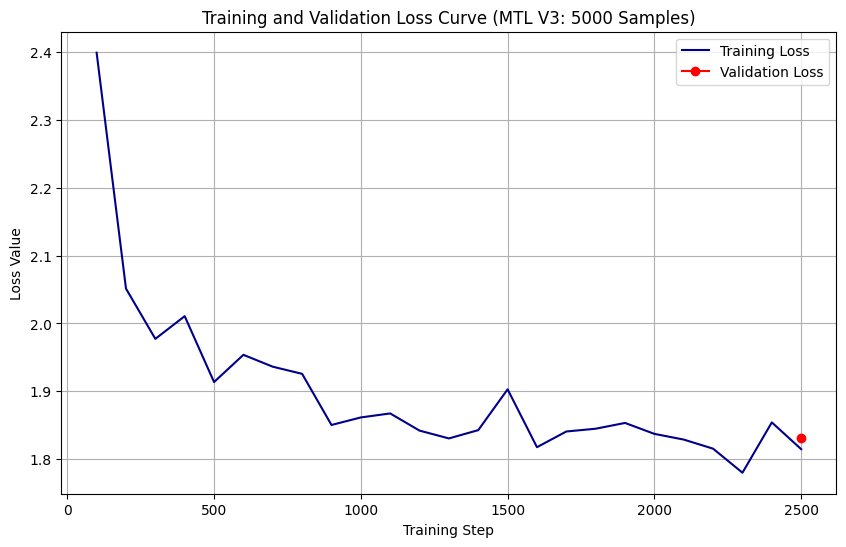

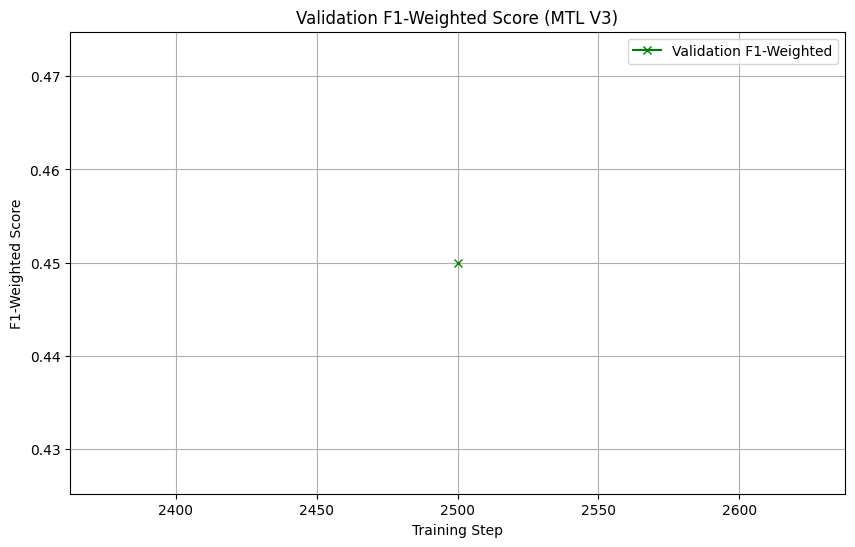


Generating Predictions for Confusion Matrix...


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


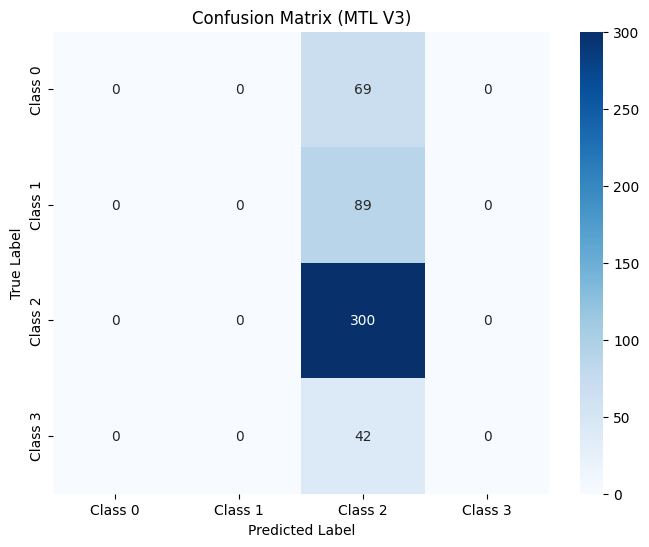


Visualization generation complete. Please use the generated charts in your paper.


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
import evaluate



log_df = pd.DataFrame(training_history)

eval_df = log_df.dropna(subset=['eval_loss'])

train_df = log_df.dropna(subset=['loss'])


plt.figure(figsize=(10, 6))
plt.plot(train_df['step'], train_df['loss'], label='Training Loss', color='darkblue')

plt.plot(eval_df['step'], eval_df['eval_loss'], label='Validation Loss', color='red', marker='o')

plt.title('Training and Validation Loss Curve (MTL V3: 5000 Samples)')
plt.xlabel('Training Step')
plt.ylabel('Loss Value')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(eval_df['step'], eval_df['eval_f1_weighted'], label='Validation F1-Weighted', color='green', marker='x')

plt.title('Validation F1-Weighted Score (MTL V3)')
plt.xlabel('Training Step')
plt.ylabel('F1-Weighted Score')
plt.legend()
plt.grid(True)
plt.show()

print("\nGenerating Predictions for Confusion Matrix...")
predictions = mtl_trainer.predict(mtl_test_dataset)
classification_logits = predictions.predictions[0]
predicted_labels = np.argmax(classification_logits, axis=-1)
true_labels = mtl_test_dataset["labels"]

cm = confusion_matrix(true_labels, predicted_labels)

class_names = [f'Class {i}' for i in range(NUM_LABELS)]

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (MTL V3)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print("\nVisualization generation complete. Please use the generated charts in your paper.")

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
import evaluate


log_df = pd.DataFrame(training_history)
eval_df = log_df.dropna(subset=['eval_loss'])
train_df = log_df.dropna(subset=['loss'])


plt.figure(figsize=(10, 6))
plt.plot(train_df['step'], train_df['loss'], label='Training Loss', color='darkblue')
plt.plot(eval_df['step'], eval_df['eval_loss'], label='Validation Loss', color='red', marker='o')
plt.title('Training and Validation Loss Curve (MTL V3: 5000 Samples)')
plt.xlabel('Training Step')
plt.ylabel('Loss Value')
plt.legend()
plt.grid(True)
plt.savefig("loss_curve.pdf", bbox_inches='tight')
plt.close()

print("1. 'loss_curve.pdf' successfully saved.")



plt.figure(figsize=(10, 6))
plt.plot(eval_df['step'], eval_df['eval_f1_weighted'], label='Validation F1-Weighted', color='green', marker='x')
plt.title('Validation F1-Weighted Score (MTL V3)')
plt.xlabel('Training Step')
plt.ylabel('F1-Weighted Score')
plt.legend()
plt.grid(True)
plt.savefig("f1_curve.pdf", bbox_inches='tight')
plt.close()

print("2. 'f1_curve.pdf' successfully saved.")


predictions = mtl_trainer.predict(mtl_test_dataset)
classification_logits = predictions.predictions[0]
predicted_labels = np.argmax(classification_logits, axis=-1)
true_labels = mtl_test_dataset["labels"]

cm = confusion_matrix(true_labels, predicted_labels)
class_names = [f'Class {i}' for i in range(NUM_LABELS)]


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (MTL V3)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig("confusion_matrix.pdf", bbox_inches='tight')
plt.close()

print("3. 'confusion_matrix.pdf' successfully saved.")




1. 'loss_curve.pdf' successfully saved.
2. 'f1_curve.pdf' successfully saved.


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


3. 'confusion_matrix.pdf' successfully saved.
